In [1]:
# ✅ Step 0: Install Required Packages
!pip install datasets transformers sentencepiece matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
# ✅ Step 1: Import Libraries
import pandas as pd
import torch
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [3]:
# ✅ Step 2: Load CNN/DailyMail Dataset (18k samples)
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:18000]")
df = pd.DataFrame({
    "article": dataset["article"],
    "summary": dataset["highlights"]
})
df.to_csv("cnn_dailymail_15k.csv", index=False)
print("CSV saved as 'cnn_dailymail_15k.csv'")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

CSV saved as 'cnn_dailymail_15k.csv'


In [4]:
# ✅ Step 3: Train-Validation Split
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
print(f"Training Samples: {len(train_df)}, Validation Samples: {len(val_df)}")


Training Samples: 16200, Validation Samples: 1800


In [5]:
# ✅ Step 4: Dataset Class
class TextSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_len=512, max_output_len=150):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_text = "summarize: " + self.data.iloc[idx]["article"]
        target_text = self.data.iloc[idx]["summary"]

        inputs = self.tokenizer(
            input_text,
            max_length=self.max_input_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        targets = self.tokenizer(
            target_text,
            max_length=self.max_output_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": targets["input_ids"].squeeze()
        }

In [6]:
# ✅ Step 5: Tokenizer & Dataloader
tokenizer = T5Tokenizer.from_pretrained("t5-base")
train_dataset = TextSummaryDataset(train_df, tokenizer)
val_dataset = TextSummaryDataset(val_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
# ✅ Step 6: Load Model
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [8]:
# ✅ Step 7: Optimizer (lower LR to reduce overfitting)
optimizer = AdamW(model.parameters(), lr=3e-5)

In [13]:
# ✅ Step 8: Training with Early Stopping & Save Best Model
num_epochs = 2
patience = 2
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔍 Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"\n📢 Epoch {epoch+1} Completed!")
    print(f"✅ Avg Train Loss: {avg_train_loss:.4f}")
    print(f"✅ Avg Val Loss: {avg_val_loss:.4f}")

    # Save model if validation improves
    if avg_val_loss < best_val_loss:
        print("✅ Validation loss improved — saving model.")
        best_val_loss = avg_val_loss
        model.save_pretrained("best_t5_model")
        tokenizer.save_pretrained("best_t5_model")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print("❌ No improvement in validation loss.")
        if early_stop_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

Epoch 1: 100%|██████████| 2025/2025 [46:37<00:00,  1.38s/it, loss=0.67]



📢 Epoch 1 Completed!
✅ Avg Train Loss: 0.6430
✅ Avg Val Loss: 0.5805
✅ Validation loss improved — saving model.


Epoch 2: 100%|██████████| 2025/2025 [46:39<00:00,  1.38s/it, loss=0.694]



📢 Epoch 2 Completed!
✅ Avg Train Loss: 0.6208
✅ Avg Val Loss: 0.5797
✅ Validation loss improved — saving model.


In [14]:
# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# ✅ Replace this path with your desired Drive folder
model_save_path = "/content/drive/MyDrive/t5_summarization_model_base01"

# Save the best model to Google Drive
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to Google Drive at: {model_save_path}")


Model saved to Google Drive at: /content/drive/MyDrive/t5_summarization_model_base01


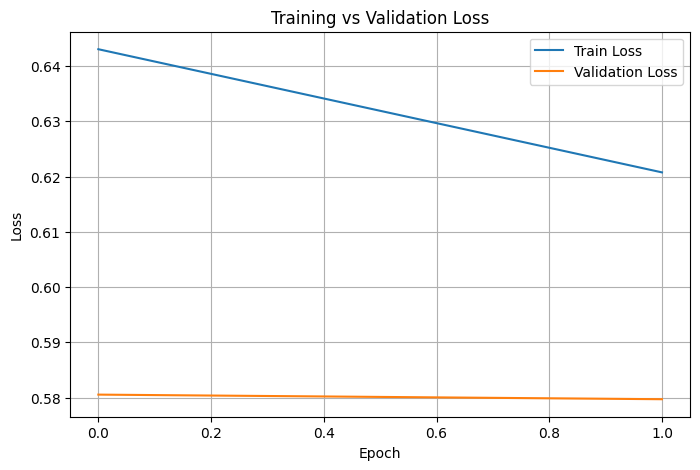

In [16]:
# ✅ Step 9: Plot Training vs Validation Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [17]:
def summarize_text(text, max_input_length=512, max_output_length=150):
    input_text = "summarize: " + text.strip().replace("\n", " ")
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    ).to(device)

    # Generate summary
    summary_ids = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# 🔍 Try summarizing
sample_text = "Artificial Intelligence is revolutionizing how we interact with technology in daily life. From voice assistants like Alexa and Siri to recommendation systems on Netflix and YouTube, AI is deeply embedded in modern software. Businesses are leveraging AI to optimize logistics, predict customer behavior, and enhance cybersecurity. In healthcare, machine learning models are used to detect diseases early and assist in treatment planning. Despite its benefits, AI raises ethical questions about data privacy, algorithmic bias, and job automation."
summary = summarize_text(sample_text)
print("📃 Summary:", summary)


📃 Summary: Artificial Intelligence is revolutionizing how we interact with technology in daily life . From voice assistants like Alexa and Siri to recommendation systems on Netflix and YouTube, AI is deeply embedded in modern software . In healthcare, machine learning models are used to detect diseases early .
